In [191]:
from headers import *
%matplotlib notebook

Defining a Class for DMPs

In [192]:
class DMP():
	
	def __init__(self,timesteps=100):

		self.alphaz = 25.0
		self.betaz = self.alphaz/4
		self.alpha = 1*self.alphaz/3    

		self.time_steps = timesteps
		self.tau = self.time_steps

		self.dimensions = 3
		self.number_kernels = 100
		self.gaussian_kernels = npy.zeros((self.number_kernels,2))

		self.weights = npy.zeros((self.number_kernels, self.dimensions))

		self.demo_pos = npy.zeros((self.time_steps, self.dimensions))
		self.demo_vel = npy.zeros((self.time_steps, self.dimensions))
		self.demo_acc = npy.zeros((self.time_steps, self.dimensions))

		self.target_forces = npy.zeros((self.time_steps, self.dimensions))        
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))
		self.vector_phase = npy.zeros(self.time_steps)
        
# Defining Rollout variables.
		self.rollout_time = self.time_steps
# 		self.rollout_time = 200
		self.dt = 1./self.rollout_time
		self.pos_roll = npy.zeros((self.rollout_time+1,self.dimensions))
		self.vel_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.acc_roll = npy.zeros((self.rollout_time,self.dimensions))
		self.force_roll = npy.zeros((self.rollout_time,self.dimensions))        
		self.pos_var = npy.zeros(self.dimensions)
		self.vel_var = npy.zeros(self.dimensions)
		self.acc_var = npy.zeros(self.dimensions)        
		self.force_var = npy.zeros(self.dimensions)        
		self.goal = npy.zeros(self.dimensions)
		self.start = npy.zeros(self.dimensions)        

	def load_trajectory(self,pos,vel,acc):
		self.demo_pos = copy.deepcopy(pos)
		self.demo_vel = copy.deepcopy(vel)
		self.demo_acc = copy.deepcopy(acc)

	def initialize_variables(self):	
		self.weights = npy.zeros((self.number_kernels, self.dimensions))
		self.target_forces = npy.zeros((self.time_steps, self.dimensions))
		self.phi = npy.zeros((self.number_kernels, self.time_steps, self.time_steps))
		self.eta = npy.zeros((self.time_steps, self.dimensions))

		t_range = npy.linspace(0,self.time_steps,self.number_kernels)
		self.vector_phase = self.calc_vector_phase(t_range)
		self.gaussian_kernels[:,0] = self.vector_phase

# 		self.gaussian_kernels[:,1] = self.number_kernels/self.gaussian_kernels[:,0]       
# 		dummy = (npy.diff(self.gaussian_kernels[:,0]*2))**2        
		dummy = (npy.diff(self.gaussian_kernels[:,0]*0.55))**2            
		self.gaussian_kernels[:,1] = 1. / npy.append(dummy,dummy[-1])

	def calc_phase(self,time):
		return npy.exp(-self.alpha*float(time)/self.tau)
    
	def calc_vector_phase(self,time):
		return npy.exp(-self.alpha*time.astype(float)/self.tau)

	def basis(self,index,time):
		return npy.exp(-(self.gaussian_kernels[index,1])*((self.calc_phase(time)-self.gaussian_kernels[index,0])**2))

	def update_target_force(self):
		self.target_forces = self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel)
    
  	def update_target_force_itau(self):
		self.target_forces = (self.tau**2)*self.demo_acc - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.tau*self.demo_vel)
        
  	def update_target_force_dtau(self):
		self.target_forces = self.demo_acc/(self.tau**2) - self.alphaz*(self.betaz*(self.demo_pos[self.time_steps-1]-self.demo_pos)-self.demo_vel/self.tau)    

	def update_phi(self):		
		for i in range(self.number_kernels):
			for t in range(self.time_steps):
				self.phi[i,t,t] = self.basis(i,t)                
                
	def update_eta(self):        
		t_range = npy.linspace(0,self.time_steps,self.time_steps)        
		vector_phase = self.calc_vector_phase(t_range)        
        
		for k in range(self.dimensions):
			self.eta[:,k] = vector_phase*(self.demo_pos[-1,k]-self.demo_pos[0,k])

	def learn_DMP(self):	
# 		self.update_target_force()        
		self.update_phi()
		self.update_eta()

		for j in range(self.dimensions):
			for i in range(self.number_kernels):
				self.weights[i,j] = npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.target_forces[:,j]))
				self.weights[i,j] /= npy.dot(self.eta[:,j],npy.dot(self.phi[i],self.eta[:,j]))

	def save_DMP_parameters(self,file_suffix):

		with file("force_weights_{0}.npy".format(file_suffix),'w') as outfile:
			npy.save(outfile,self.weights)
	
		with file("position_{0}.npy".format(file_suffix),'w') as outfile:
			npy.save(outfile, self.demo_pos)
            
	def shebang(self,pos,vel,acc):
		dmp.load_trajectory(pos,vel,acc)
		dmp.initialize_variables()
		dmp.learn_DMP() 
        
	def initialize_rollout(self,start,goal):
		self.tau = 1
		self.pos_var = copy.deepcopy(start)
		self.pos_roll[0] = copy.deepcopy(start)
		self.vel_var = npy.zeros(self.dimensions)
		self.vel_roll = npy.zeros((self.rollout_time,self.dimensions))        
		self.goal = goal
		self.start = start
		self.dt = 1./self.rollout_time    

	def calc_rollout_force(self,roll_time):
		den = 0        
		time = float(roll_time)/self.rollout_time           
# 		print(roll_time,time,self.calc_phase(time),self.tau)
		for i in range(self.number_kernels):
			self.force_roll[roll_time] += self.basis(i,time)*self.weights[i]
			den += self.basis(i,time)
		self.force_roll[roll_time] *= (self.goal-self.start)*self.calc_phase(time)/den        
            
	def calc_rollout_acceleration(self,time):        
		self.acc_var = (1/self.tau**2)*(self.alphaz * (self.betaz * (self.goal - self.pos_var) - self.tau*self.vel_var) + self.force_roll[time])
		self.acc_roll[time] = copy.deepcopy(self.acc_var)
        
	def calc_rollout_vel(self,time):
		self.vel_var += (1/self.tau)*self.acc_var*self.dt
		self.vel_roll[time] = copy.deepcopy(self.vel_var)

	def calc_rollout_pos(self,time):
		self.pos_var += self.vel_var * self.dt 
# 		self.pos_var += self.vel_var * self.dt + 0.5 * self.acc_var *(self.dt**2)        
		self.pos_roll[time+1] = copy.deepcopy(self.pos_var)

	def rollout(self,start,goal):

		# For all time: 
		self.initialize_rollout(start,goal)
		for i in range(self.rollout_time):        
			self.calc_rollout_force(i)
			self.calc_rollout_acceleration(i)
			self.calc_rollout_vel(i)
			self.calc_rollout_pos(i)   

In [193]:
# cd ../../Data/Cornell_Data/Primitive_Library/Subject1/Traj_18

In [194]:
i1 = 101
i2 = 144
dmp = DMP(i2-i1)	

# pos = npy.load("lh_pos.npy")[:,:3]
# vel = npy.load("lh_vel.npy")[:,:3]
# acc = npy.load("lh_acc.npy")[:,:3]

pos = npy.load("left_hand_pos_18.npy")[i1:i2,:3]
vel = npy.load("left_hand_vel_18.npy")[i1:i2,:3]
acc = npy.load("left_hand_acc_18.npy")[i1:i2,:3]

# ts = 1000
ts = 1
vel *= ts
acc *= (ts**2)

In [195]:
dmp.load_trajectory(pos,vel,acc)
dmp.initialize_variables()
# dmp.update_target_force()
dmp.update_target_force_itau()
# dmp.update_target_force_dtau()
dmp.learn_DMP()

tr = npy.linspace(0,dmp.time_steps-1,dmp.time_steps)

43


<IPython.core.display.Javascript object>


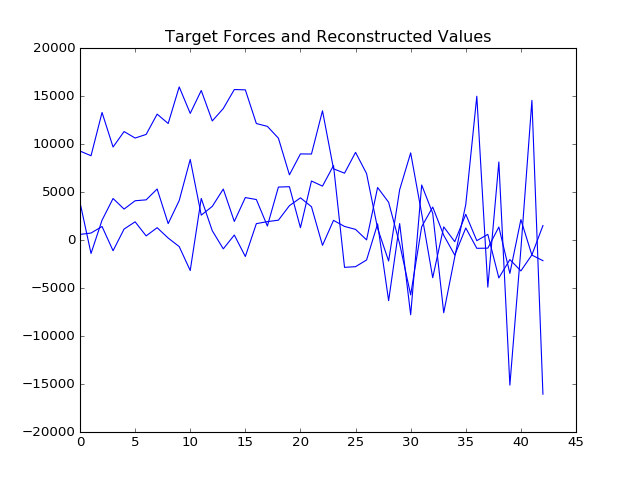

In [202]:
force = npy.zeros((dmp.time_steps,dmp.dimensions))
dmp.goal = copy.deepcopy(dmp.demo_pos[-1])
print(dmp.tau)
for t in range(dmp.time_steps):
    den = 0
    for i in range(dmp.number_kernels):
        force[t] += dmp.weights[i]*dmp.basis(i,t)
        den += dmp.basis(i,t)   
    for k in range(dmp.dimensions):
        force[t,k]*=(dmp.goal[0]-dmp.demo_pos[0,k])*dmp.calc_phase(t)/den
#         force[t,k]*=(dmp.goal[k]-dmp.start[k])*dmp.calc_phase(t)/den
# plt.plot(tr,force,'r',label='Reconstructed Forces')
plt.plot(tr,dmp.target_forces,'b',label='Target Forces')
plt.title("Target Forces and Reconstructed Values")
# plt.savefig("Target_Reconstructed_{0}.png".format(st),bbox_inches='tight')
plt.show()

In [169]:
start = npy.zeros(dmp.dimensions)
goal = npy.ones(dmp.dimensions)
dmp.rollout(start, goal)

In [170]:
# b = npy.zeros((dmp.number_kernels,dmp.time_steps))
# # dmp.tau = 100
# # dmp.gaussian_kern
# # for i in range(dmp.number_kernels):
# #     for t in range(dmp.time_steps):
# #         b[i,t]=dmp.basis(i,t)        
# #     plt.plot(tr,b[i])    
# k=100
# for i in range(k):
#     for t in range(dmp.time_steps):
#         b[i,t]=dmp.basis(i*(100/k),t)        
#     plt.plot(tr,b[i])    
    
    
# plt.show()
# dmp.tau =100 

<IPython.core.display.Javascript object>


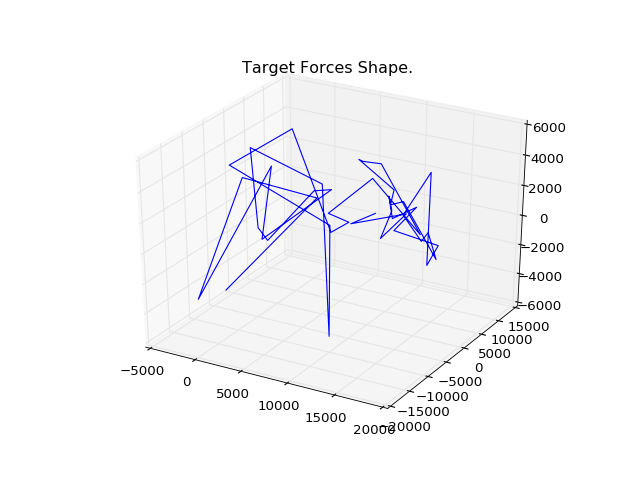

In [183]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(dmp.target_forces[:,0],dmp.target_forces[:,1],dmp.target_forces[:,2])
# plt.plot(dmp.target_forces[:,0],dmp.target_forces[:,1])
plt.title("Target Forces Shape.")
# plt.savefig("Target_Forces_{0}.png".format(st),bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


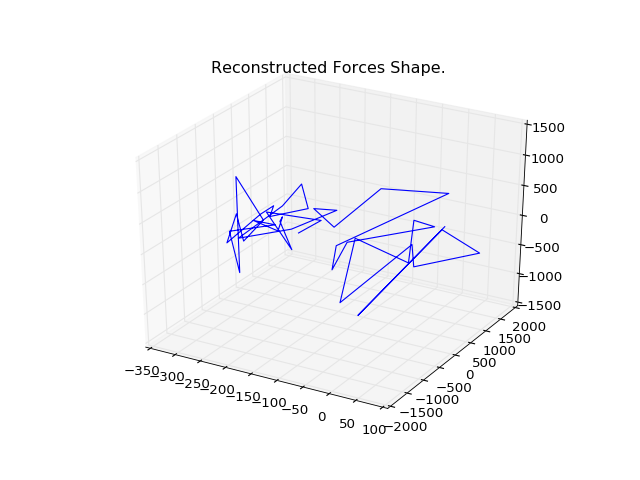

In [184]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(dmp.force_roll[:,0],dmp.force_roll[:,1],dmp.force_roll[:,2])
# plt.plot(dmp.target_forces[:,0],dmp.target_forces[:,1])
plt.title("Reconstructed Forces Shape.")
# plt.savefig("Reconstructed_Forces_{0}.png".format(st),bbox_inches='tight')
plt.show()

In [173]:
# fig = plt.figure()
# ax = fig.gca(projection='3d')

# np = copy.deepcopy(dmp.demo_pos)
# np -= np[0]
# np /= np[-1]
# # ax.plot(dmp.demo_pos[:,0],dmp.demo_pos[:,1],dmp.demo_pos[:,2])
# ax.plot(np[:,0],np[:,1],np[:,2])
# plt.title("Original Trajectory Shape.")
# # plt.savefig("Reconstructed_Trajectory_{0}.png".format(st),bbox_inches='tight')
# plt.show()

In [174]:
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot(dmp.pos_roll[:,0],dmp.pos_roll[:,1],dmp.pos_roll[:,2])
# plt.title("Reconstructed Trajectory Shape.")
# # plt.savefig("Reconstructed_Trajectory_{0}.png".format(st),bbox_inches='tight')
# plt.show()

<IPython.core.display.Javascript object>


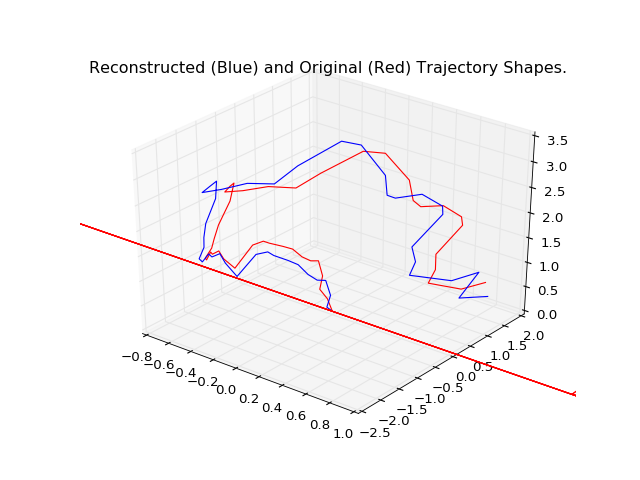

In [181]:
fig = plt.figure()
ax = fig.gca(projection='3d')

np = copy.deepcopy(dmp.demo_pos)
np -= np[0]
np /= np[-1]
ax.plot(np[:,0],np[:,1],np[:,2],'r')
ax.plot(dmp.pos_roll[:,0],dmp.pos_roll[:,1],dmp.pos_roll[:,2],'b')
# ind = [49,110,130,175]
# ax.scatter(dmp.pos_roll[ind,0],dmp.pos_roll[ind,1],dmp.pos_roll[ind,2],s=50)
plt.title("Reconstructed (Blue) and Original (Red) Trajectory Shapes.")
# plt.savefig("Reconstructed_Trajectory_{0}.png".format(st),bbox_inches='tight')
plt.show()

In [176]:
force_diff = npy.linalg.norm(npy.diff(dmp.force_roll,axis=0),axis=1)
force_norm = npy.linalg.norm(dmp.force_roll,axis=1)
# # plt.plot(range(dmp.time_steps-1),abs(npy.diff(force_norm,axis=0)))
# plt.plot(range(dmp.rollout_time-1),force_diff)
# plt.title("Consistency Norm of Diff of Force Rollout")
# plt.show()

In [177]:
# vel_norm = npy.linalg.norm(dmp.vel_roll,axis=1)
# plt.plot(range(dmp.rollout_time),vel_norm)
# plt.show()

In [178]:
normalized_forces = copy.deepcopy(dmp.force_roll)
# normalized_forces = dmp.force_roll/force_norm
for k in range(dmp.dimensions):
    normalized_forces[:,k] /= force_norm

In [179]:
force_dot_prod = npy.zeros(dmp.rollout_time-1)
for i in range(dmp.rollout_time-1):
    force_dot_prod[i] = npy.dot(normalized_forces[i],normalized_forces[i+1])


In [180]:
# plt.plot(range(dmp.rollout_time-1),force_dot_prod)
# plt.show()